<a href="https://colab.research.google.com/github/mananchichra/Image_classification/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

# Adjust the file name to match your uploaded file
with zipfile.ZipFile('/content/drive/My Drive/double_mnist.zip', 'r') as zip_ref:
    zip_ref.extractall('double_mnist')


In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class MultiMNISTDataset(Dataset):
    def __init__(self, data_dir, split='train', transform=None):
        self.data_dir = os.path.join(data_dir, split)
        self.transform = transform
        self.images = []
        self.labels = []

        # Load images and labels
        for label in os.listdir(self.data_dir):
            label_dir = os.path.join(self.data_dir, label)
            if os.path.isdir(label_dir):
                for img_file in os.listdir(label_dir):
                    img_path = os.path.join(label_dir, img_file)
                    if img_file.endswith('.png'):  # Assuming images are in PNG format
                        self.images.append(img_path)
                        self.labels.append(len(label))  # Number of digits in the subfolder name

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        if self.transform:
            image = self.transform(image)
        return image, label

def load_mnist_data(data_dir, batch_size=32, transform=None):
    # Define transforms
    if transform is None:
        transform = transforms.Compose([
            transforms.Resize((28, 28)),  # Assuming we want to resize to 28x28
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    train_dataset = MultiMNISTDataset(data_dir, split='train', transform=transform)
    val_dataset = MultiMNISTDataset(data_dir, split='val', transform=transform)
    test_dataset = MultiMNISTDataset(data_dir, split='test', transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, task='classification'):
        super(CNN, self).__init__()
        self.task = task

        # Define CNN layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2_classification = nn.Linear(128, 10)  # For 10 classes
        self.fc2_regression = nn.Linear(128, 1)  # For regression

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 64 * 7 * 7)  # Flatten the tensor
        x = F.relu(self.fc1(x))

        if self.task == 'classification':
            x = self.fc2_classification(x)
        elif self.task == 'regression':
            x = self.fc2_regression(x)

        return x
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

class CNN_tuning(nn.Module):
    def __init__(self, num_layers=2, dropout_rate=0.5, task='classification'):
        super().__init__()

        # Adjust number of convolutional layers
        self.convs = nn.ModuleList()
        in_channels = 1  # starting with grayscale input (assuming 1 channel for MNIST)
        for i in range(num_layers):
            self.convs.append(nn.Conv2d(in_channels, 32 * (i+1), kernel_size=3, padding=1))
            in_channels = 32 * (i+1)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)

        # Calculate the size after conv layers by using a dummy input
        self._initialize_fc1_input_size()

        # Define fully connected layers
        self.fc1 = nn.Linear(self.fc1_input_size, 128)
        self.fc2 = nn.Linear(128, 10 if task == 'classification' else 1)

        self.task = task

    def _initialize_fc1_input_size(self):
        # Create a dummy input with the same dimensions as your input data
        dummy_input = torch.zeros(1, 1, 28, 28)  # MNIST images are 28x28
        x = dummy_input
        for conv in self.convs:
            x = self.pool(F.relu(conv(x)))

        # Flatten x to find the size for fc1
        self.fc1_input_size = x.numel()  # This gives total number of elements

    def forward(self, x):
        # Forward through convolutional layers
        for conv in self.convs:
            x = self.pool(F.relu(conv(x)))

        # Flatten the output
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        if self.task == 'classification':
            return F.log_softmax(x, dim=1)
        else:
            return x  # For regression, no activation applied


In [13]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=15):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images, labels#.cuda()  # Move to GPU if available
            optimizer.zero_grad()
            outputs = model(images)
            # loss = criterion(outputs, labels)
            if model.task == 'classification':
                # For classification, use CrossEntropyLoss and ensure labels are within the valid range
                loss = criterion(outputs, labels)
            elif model.task == 'regression':
                # If task is regression, you can continue to use CrossEntropyLoss but may need to consider different output and loss calculations.
                # Replace CrossEntropyLoss with a suitable regression loss function.
                criterion_reg = nn.MSELoss()  # Example: Mean Squared Error Loss
                loss = criterion_reg(outputs.squeeze(), labels.float())

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images, labels
                outputs = model(images)
                if model.task == 'classification':
                    loss = criterion(outputs, labels)
                elif model.task == 'regression':
                    criterion_reg = nn.MSELoss()
                    loss = criterion_reg(outputs.squeeze(), labels.float())

                # loss = criterion(outputs, labels)
                val_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# Example of how to use this:
model = CNN(task='classification') #.cuda()
model_reg = CNN(task='regression')#.cuda()
criterion = nn.CrossEntropyLoss()  # For classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loader, val_loader, _ = load_mnist_data('/content/double_mnist/double_mnist')

train_model(model, criterion, optimizer, train_loader, val_loader)
train_model(model_reg, criterion, optimizer, train_loader, val_loader)

Epoch 1/15, Training Loss: 0.3220755128062278, Validation Loss: 0.031939902175973325
Epoch 2/15, Training Loss: 0.019663626334611044, Validation Loss: 0.003968818559595557
Epoch 3/15, Training Loss: 0.013542869111186491, Validation Loss: 0.0016879761409106873
Epoch 4/15, Training Loss: 0.003368587938580115, Validation Loss: 0.0014774723107172862
Epoch 5/15, Training Loss: 0.003624695990724208, Validation Loss: 0.004858143246173146
Epoch 6/15, Training Loss: 0.0015899029049066442, Validation Loss: 0.0007407040966330548
Epoch 7/15, Training Loss: 0.011484618197732397, Validation Loss: 0.012026492590713192
Epoch 8/15, Training Loss: 0.005470576965194019, Validation Loss: 0.0005150194697783813
Epoch 9/15, Training Loss: 0.013124479208806918, Validation Loss: 0.00813279512097063
Epoch 10/15, Training Loss: 0.006300237742031415, Validation Loss: 0.0034845113018134462
Epoch 11/15, Training Loss: 0.0012851092010171942, Validation Loss: 0.00033806429497052165
Epoch 12/15, Training Loss: 0.00989

In [15]:
def test_model(model, test_loader, task='classification'):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images, labels
            outputs = model(images)
            if task == 'classification':
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            elif task == 'regression':
                predicted = outputs
                test_loss += F.mse_loss(predicted, labels).item()

    if task == 'classification':
        accuracy = correct / total
        print(f'Accuracy of the model on the test set: {accuracy * 100}%')
    elif task == 'regression':
        print(f'Regression test loss (MSE): {test_loss / len(test_loader)}')

# Example
train_model(model_reg, criterion, optimizer, train_loader, val_loader,num_epochs = 25)
_, _, test_loader = load_mnist_data('/content/double_mnist/double_mnist')
test_model(model, test_loader, task='classification')  # or 'regression'

test_model(model_reg, test_loader, task='regression')  # or 'regression'


Epoch 1/25, Training Loss: 4.202580865869668, Validation Loss: 4.372746594408725
Epoch 2/25, Training Loss: 4.203095080888816, Validation Loss: 4.372746594408725
Epoch 3/25, Training Loss: 4.202589599614216, Validation Loss: 4.372746594408725
Epoch 4/25, Training Loss: 4.203129792576514, Validation Loss: 4.372746594408725
Epoch 5/25, Training Loss: 4.20281831564637, Validation Loss: 4.372746594408725
Epoch 6/25, Training Loss: 4.20314326262111, Validation Loss: 4.372746594408725
Epoch 7/25, Training Loss: 4.202871778894802, Validation Loss: 4.372746594408725
Epoch 8/25, Training Loss: 4.203090585427841, Validation Loss: 4.372746594408725
Epoch 9/25, Training Loss: 4.203272843118851, Validation Loss: 4.372746594408725
Epoch 10/25, Training Loss: 4.203201583194248, Validation Loss: 4.372746594408725
Epoch 11/25, Training Loss: 4.2025349303550525, Validation Loss: 4.372746594408725
Epoch 12/25, Training Loss: 4.20281317693933, Validation Loss: 4.372746594408725
Epoch 13/25, Training Loss:

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [16]:
def train_and_validate_model(train_loader, val_loader, learning_rate, dropout_rate, num_layers, optimizer_type, task='classification'):
    model = CNN_tuning(num_layers=num_layers, dropout_rate=dropout_rate, task=task)

    # Define optimizer
    if optimizer_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_type == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    criterion = nn.CrossEntropyLoss() if task == 'classification' else nn.MSELoss()

    num_epochs = 10
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images, labels
            optimizer.zero_grad()
            outputs = model(images)
            # loss = criterion(outputs, labels)
            if model.task == 'classification':
                # For classification, use CrossEntropyLoss and ensure labels are within the valid range
                loss = criterion(outputs, labels)
            elif model.task == 'regression':
                # If task is regression, you can continue to use CrossEntropyLoss but may need to consider different output and loss calculations.
                # Replace CrossEntropyLoss with a suitable regression loss function.
                criterion_reg = nn.MSELoss()  # Example: Mean Squared Error Loss
                loss = criterion_reg(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images, labels
                outputs = model(images)
                # loss = criterion(outputs, labels)
                if model.task == 'classification':
                    loss = criterion(outputs, labels)
                elif model.task == 'regression':
                    criterion_reg = nn.MSELoss()
                    loss = criterion_reg(outputs.squeeze(), labels.float())

                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))

    return train_losses, val_losses


## Classification

Accuracy on Test Set : 100.00%

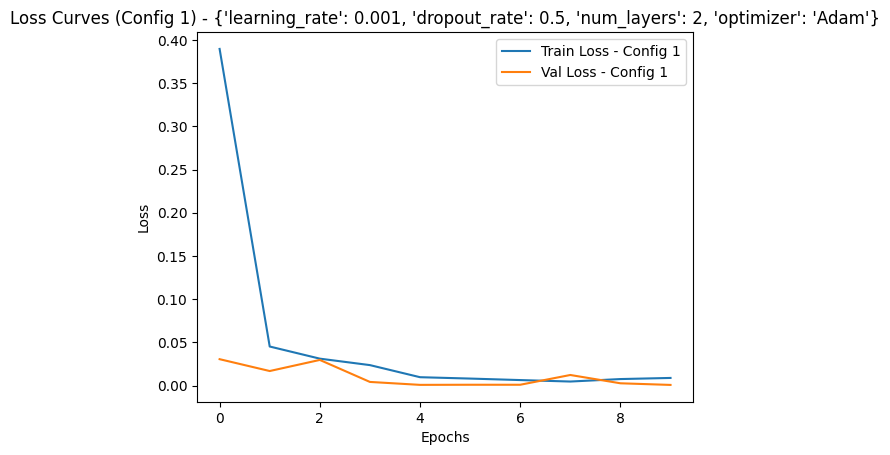

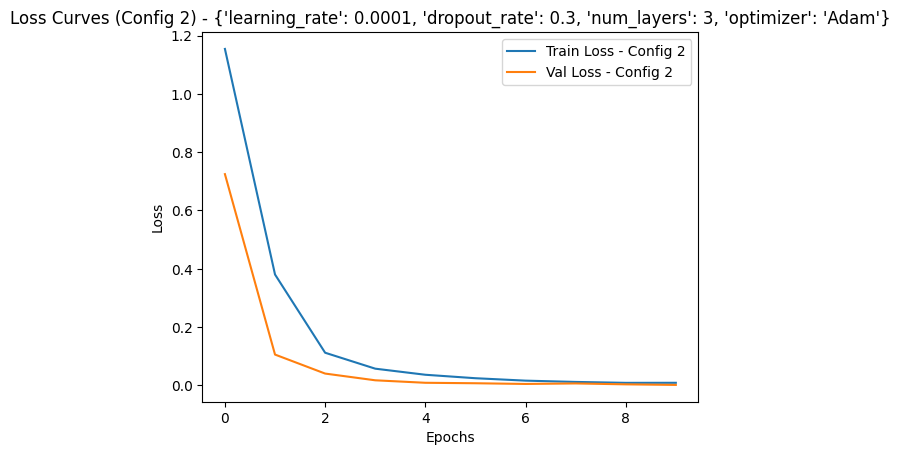

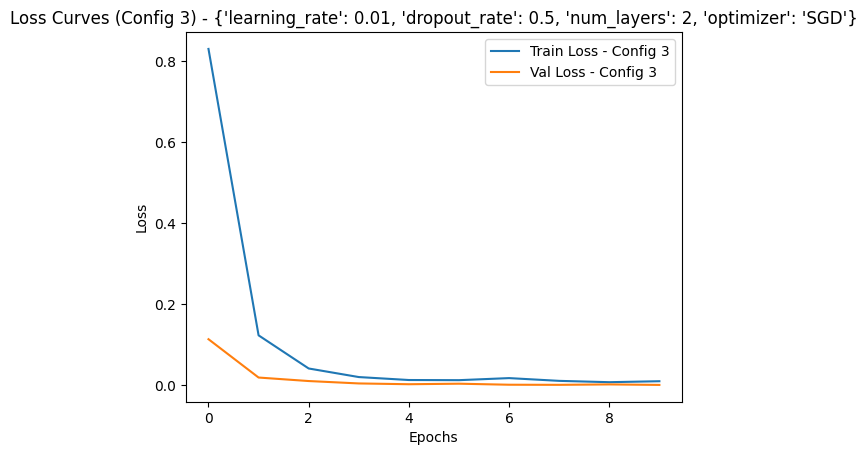

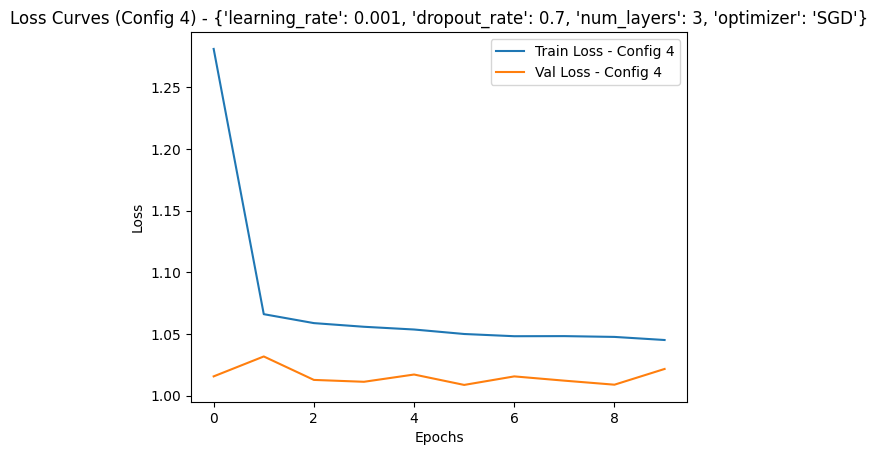

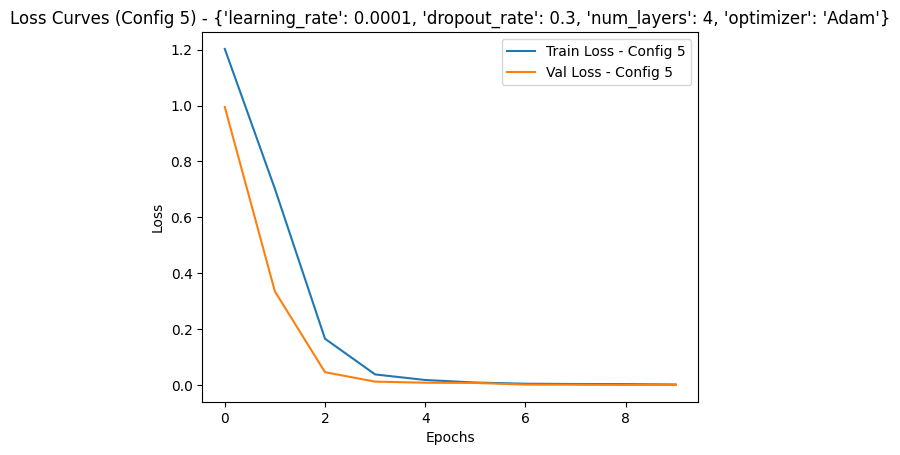

In [ ]:
import matplotlib.pyplot as plt
hyperparams = [
    {'learning_rate': 0.001, 'dropout_rate': 0.5, 'num_layers': 2, 'optimizer': 'Adam'},
    {'learning_rate': 0.0001, 'dropout_rate': 0.3, 'num_layers': 3, 'optimizer': 'Adam'},
    {'learning_rate': 0.01, 'dropout_rate': 0.5, 'num_layers': 2, 'optimizer': 'SGD'},
    {'learning_rate': 0.001, 'dropout_rate': 0.7, 'num_layers': 3, 'optimizer': 'SGD'},
    {'learning_rate': 0.0001, 'dropout_rate': 0.3, 'num_layers': 4, 'optimizer': 'Adam'}
]

for i, params in enumerate(hyperparams):
    train_losses, val_losses = train_and_validate_model(
        train_loader, val_loader,
        learning_rate=params['learning_rate'],
        dropout_rate=params['dropout_rate'],
        num_layers=params['num_layers'],
        optimizer_type=params['optimizer'],
        task='classification'  # or 'regression'
    )

    # Plot losses for each configuration
    plt.plot(train_losses, label=f"Train Loss - Config {i+1}")
    plt.plot(val_losses, label=f"Val Loss - Config {i+1}")
    plt.title(f"Loss Curves (Config {i+1}) - {params}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()



## Regression

MSE on test set : 0.4504



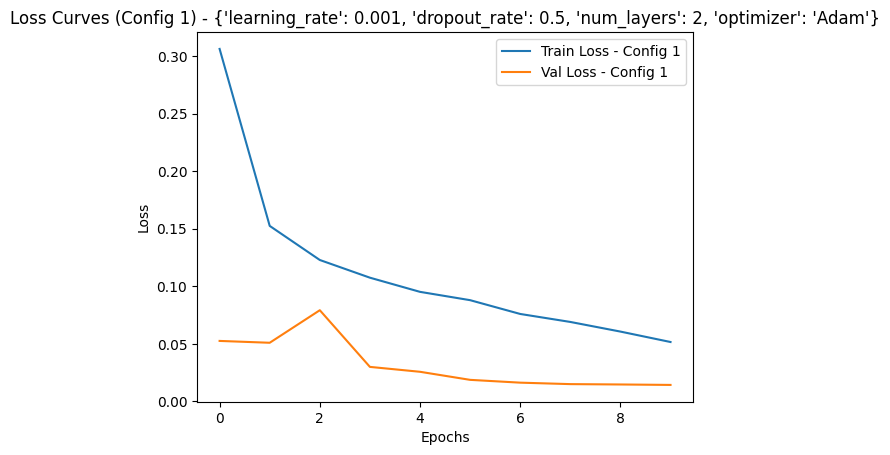

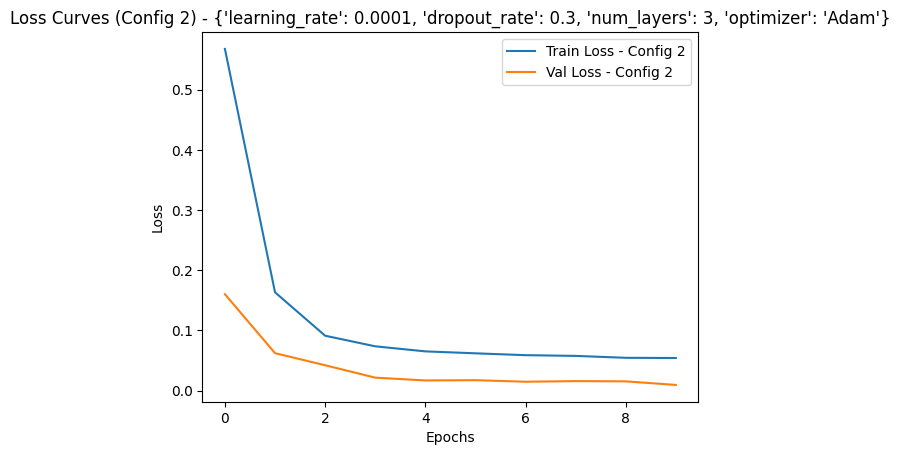

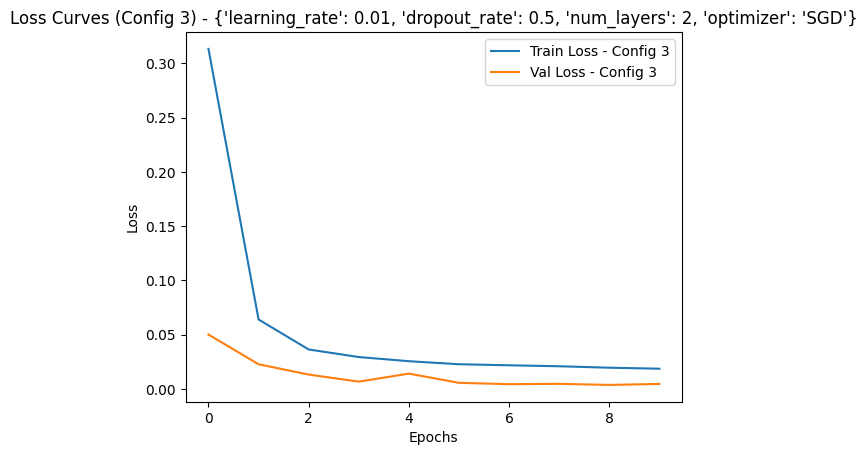

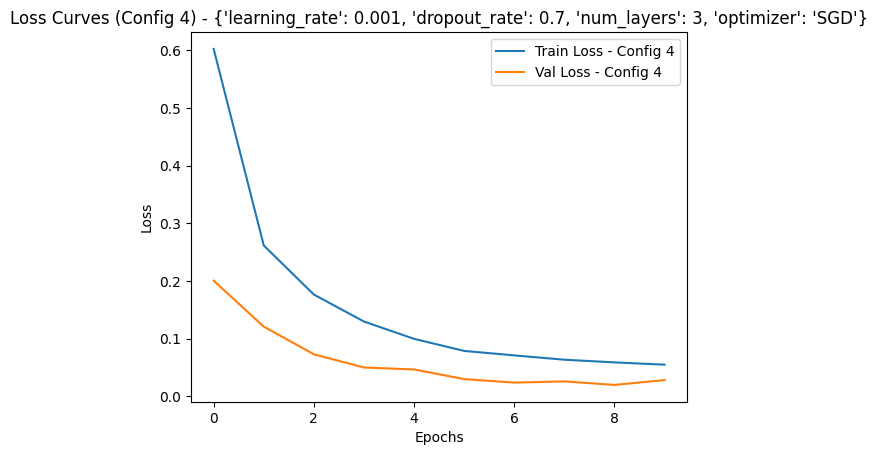

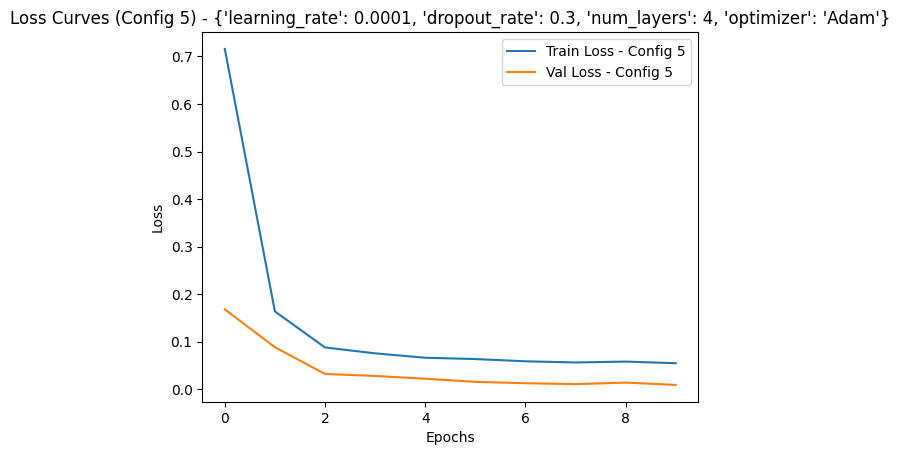

In [17]:
import matplotlib.pyplot as plt
hyperparams = [
    {'learning_rate': 0.001, 'dropout_rate': 0.5, 'num_layers': 2, 'optimizer': 'Adam'},
    {'learning_rate': 0.0001, 'dropout_rate': 0.3, 'num_layers': 3, 'optimizer': 'Adam'},
    {'learning_rate': 0.01, 'dropout_rate': 0.5, 'num_layers': 2, 'optimizer': 'SGD'},
    {'learning_rate': 0.001, 'dropout_rate': 0.7, 'num_layers': 3, 'optimizer': 'SGD'},
    {'learning_rate': 0.0001, 'dropout_rate': 0.3, 'num_layers': 4, 'optimizer': 'Adam'}
]

for i, params in enumerate(hyperparams):
    train_losses, val_losses = train_and_validate_model(
        train_loader, val_loader,
        learning_rate=params['learning_rate'],
        dropout_rate=params['dropout_rate'],
        num_layers=params['num_layers'],
        optimizer_type=params['optimizer'],
        task='regression'
    )

    # Plot losses for each configuration
    plt.plot(train_losses, label=f"Train Loss - Config {i+1}")
    plt.plot(val_losses, label=f"Val Loss - Config {i+1}")
    plt.title(f"Loss Curves (Config {i+1}) - {params}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()



In [ ]:
# Save the best model
torch.save(model.state_dict(), 'best_model.pth')

# Load the model later for testing
model.load_state_dict(torch.load('best_model.pth'))


<ipython-input-12-97a911fe2928>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

Feature Map Visualisation

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

class CNN_vis(nn.Module):
    def __init__(self, num_layers=2, dropout_rate=0.5, task='classification'):
        super().__init__()

        # Initialize convolutional layers dynamically based on num_layers
        self.convs = nn.ModuleList()
        in_channels = 1  # Starting with grayscale input (assuming 1 channel for MNIST)
        for i in range(num_layers):
            self.convs.append(nn.Conv2d(in_channels, 32 * (i+1), kernel_size=3, padding=1))
            in_channels = 32 * (i+1)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)

        # Calculate the input size for the fully connected layer
        self._initialize_fc1_input_size()

        # Define fully connected layers
        self.fc1 = nn.Linear(self.fc1_input_size, 128)
        self.fc2 = nn.Linear(128, 10 if task == 'classification' else 1)

        self.task = task

    def _initialize_fc1_input_size(self):
        # Create a dummy input with the same dimensions as your input data
        dummy_input = torch.zeros(1, 1, 28, 28)  # Assuming MNIST images are 28x28
        x = dummy_input
        for conv in self.convs:
            x = self.pool(F.relu(conv(x)))

        # Flatten x to find the size for fc1
        self.fc1_input_size = x.numel()  # Total number of elements after flattening

    def forward(self, x):
        feature_maps = []  # List to store feature maps at each layer

        # Forward pass through each conv layer while capturing feature maps
        for conv in self.convs:
            x = self.pool(F.relu(conv(x)))
            feature_maps.append(x)  # Capture feature map after each conv-pool block

        # Flatten and apply the dense layers
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        # Return both logits and feature_maps
        if self.task == 'classification':
            return F.log_softmax(x, dim=1), feature_maps
        else:
            return x, feature_maps  # For regression tasks

# Instantiate and test the model
model = CNN(num_layers=3, task='classification')
print(model)


CNN(
  (convs): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=864, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


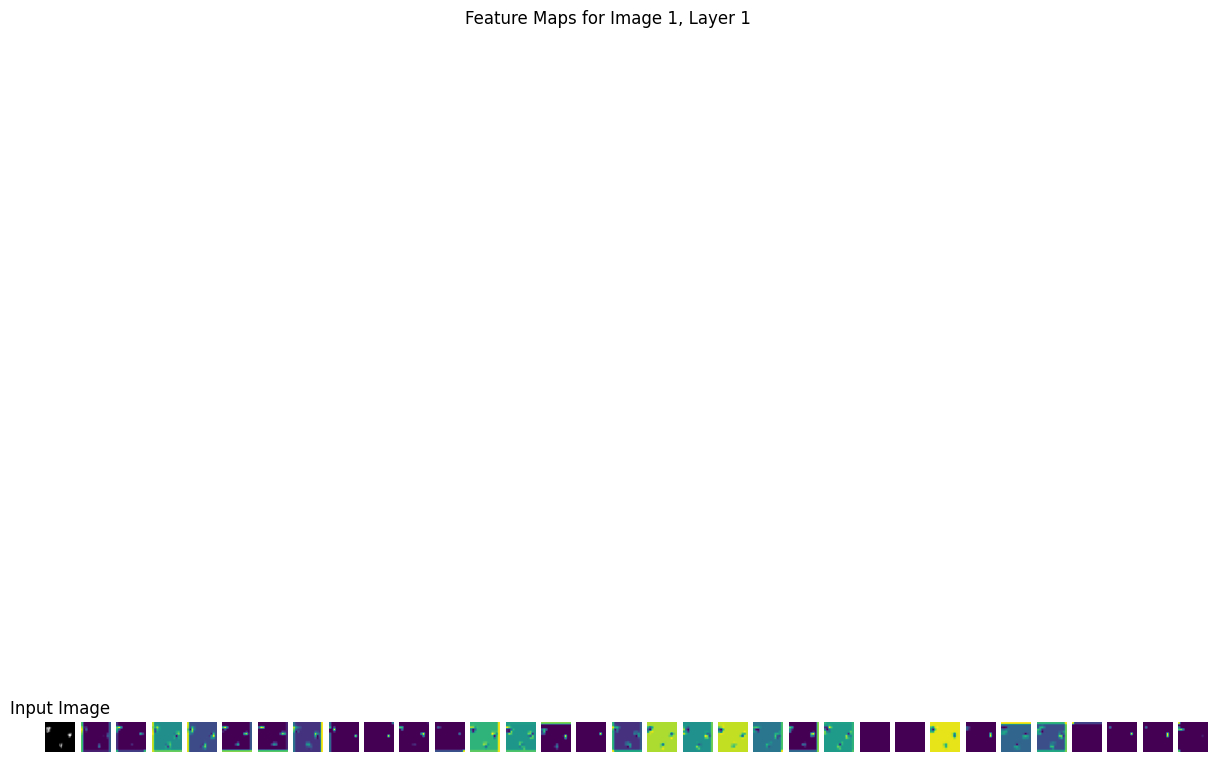

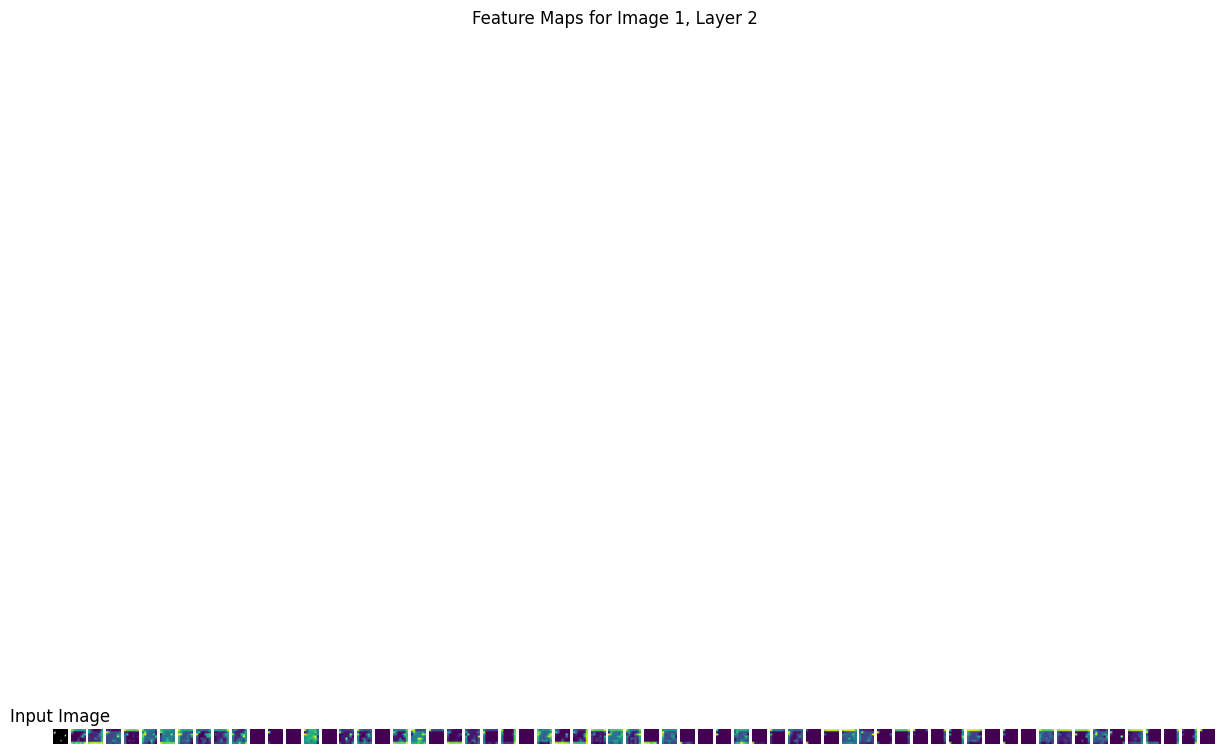

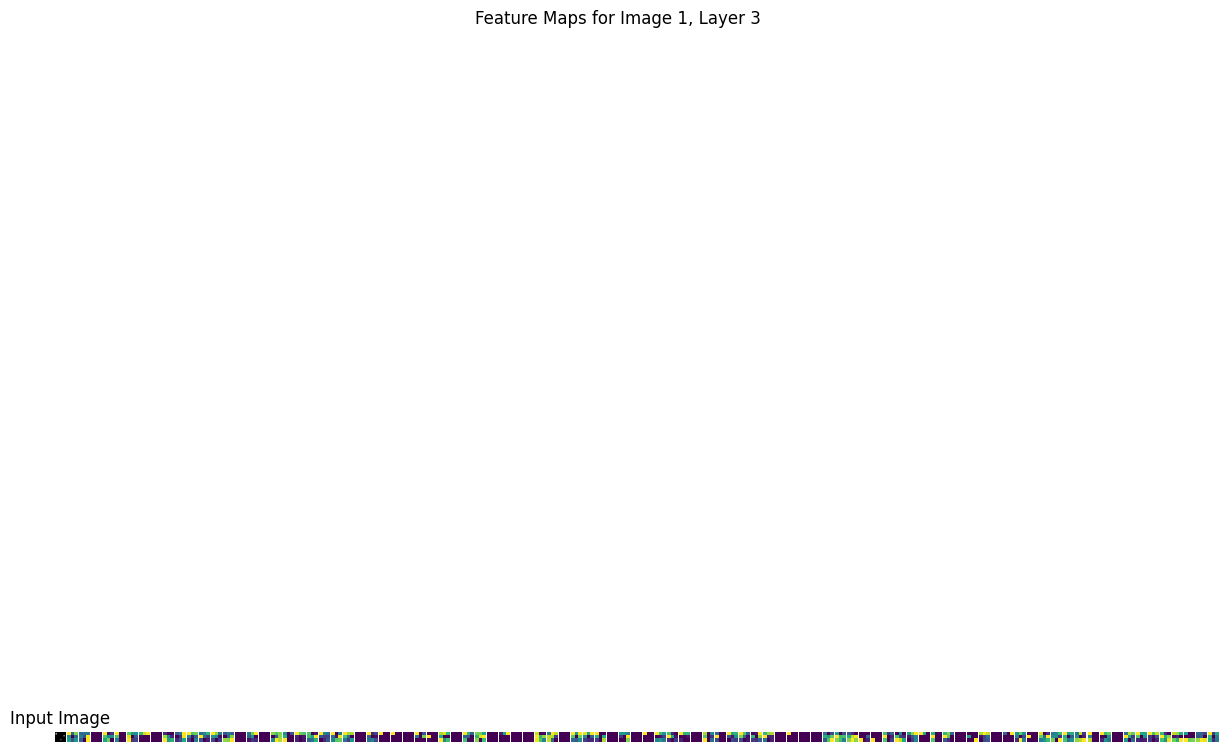

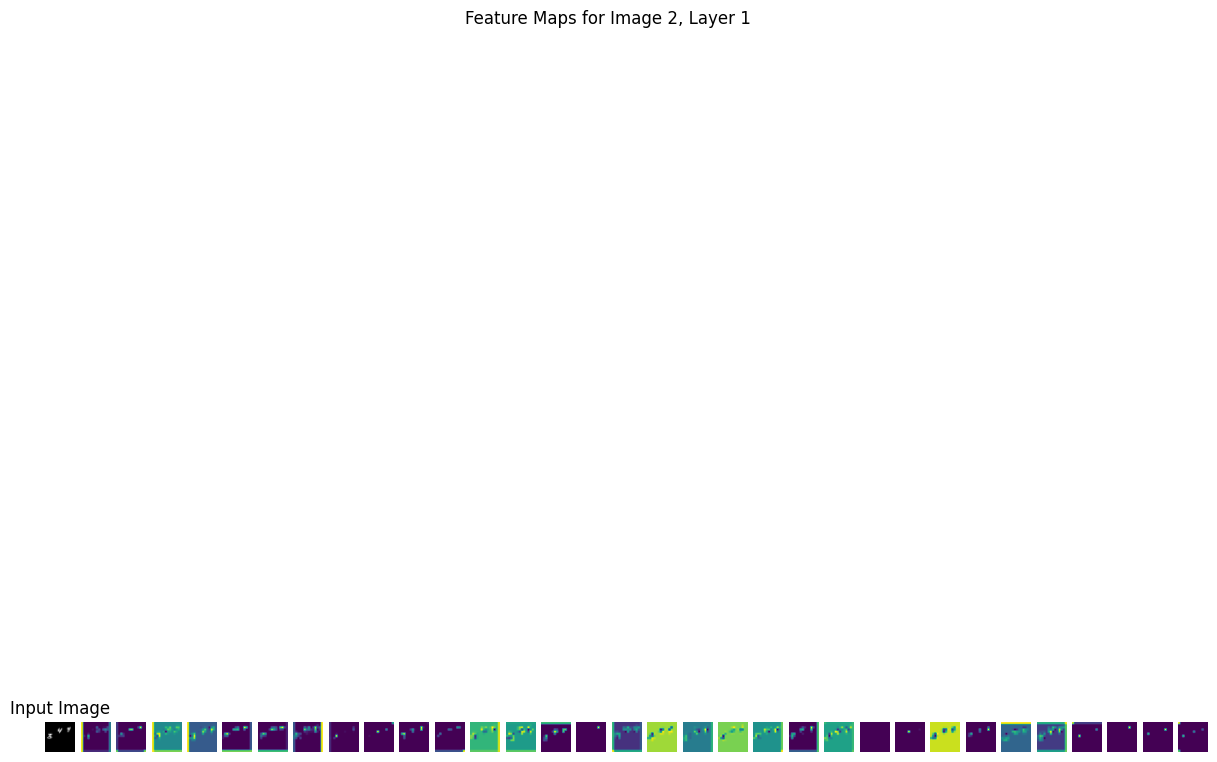

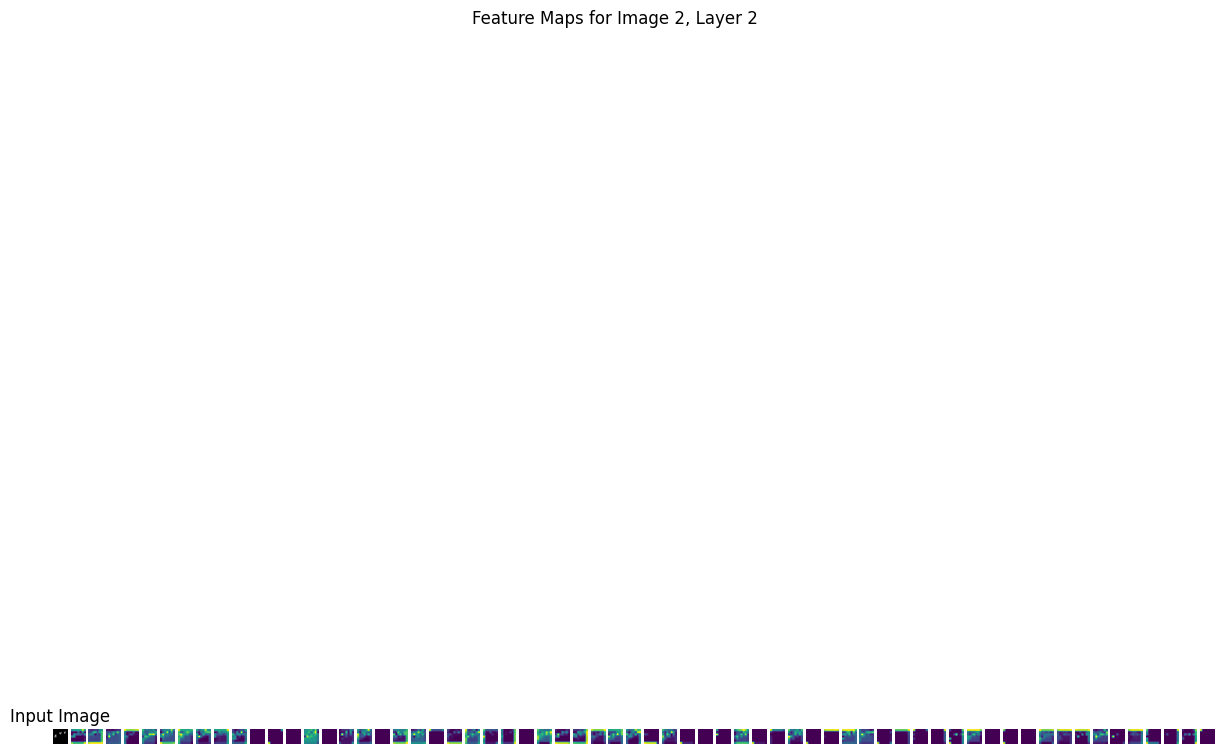

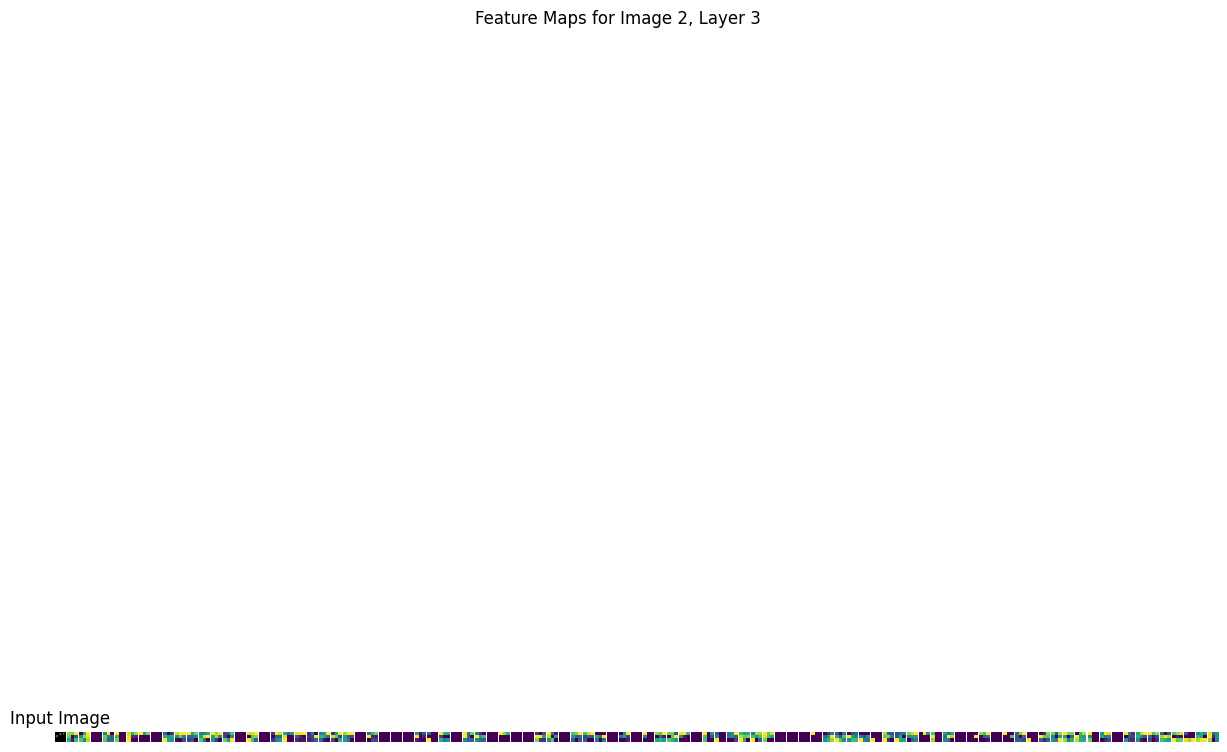

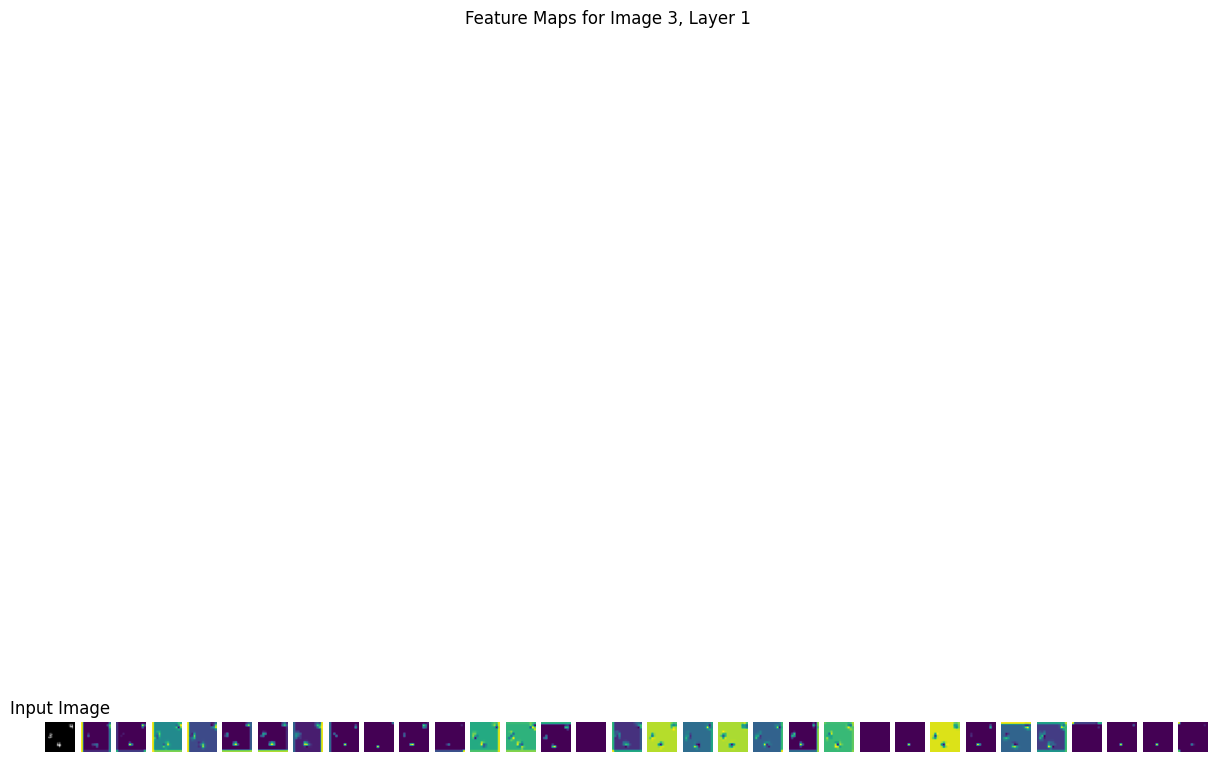

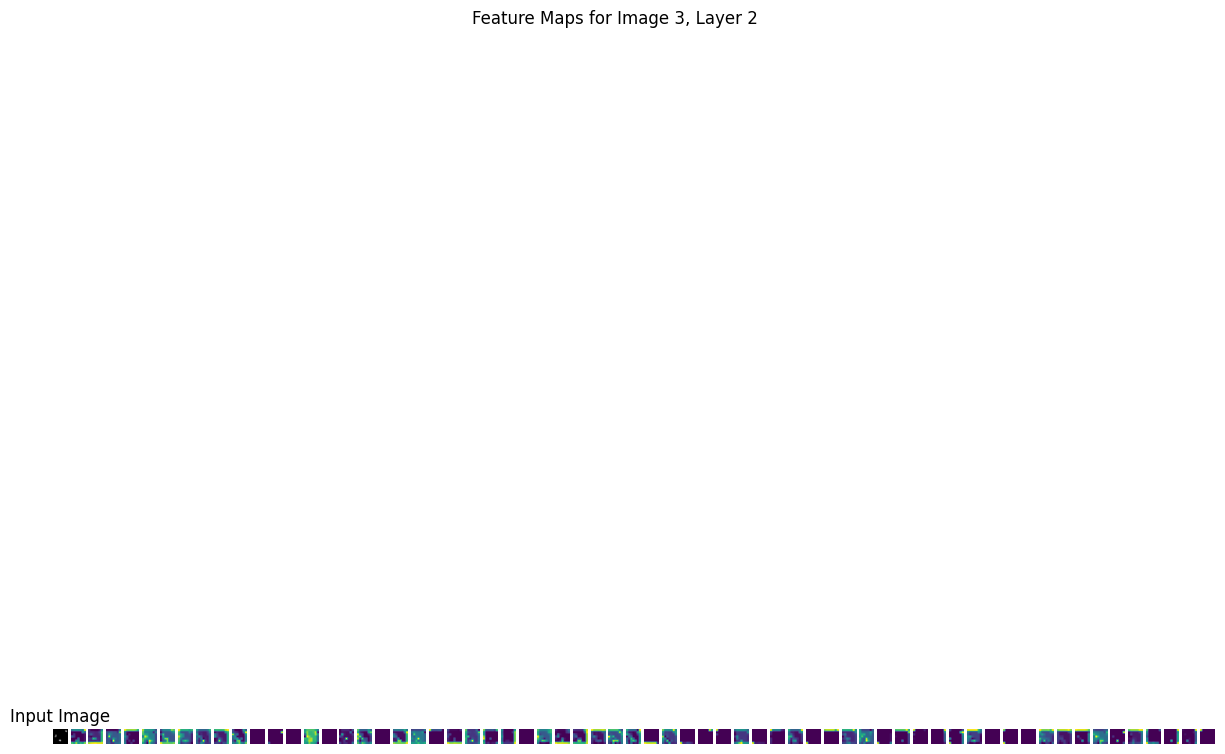

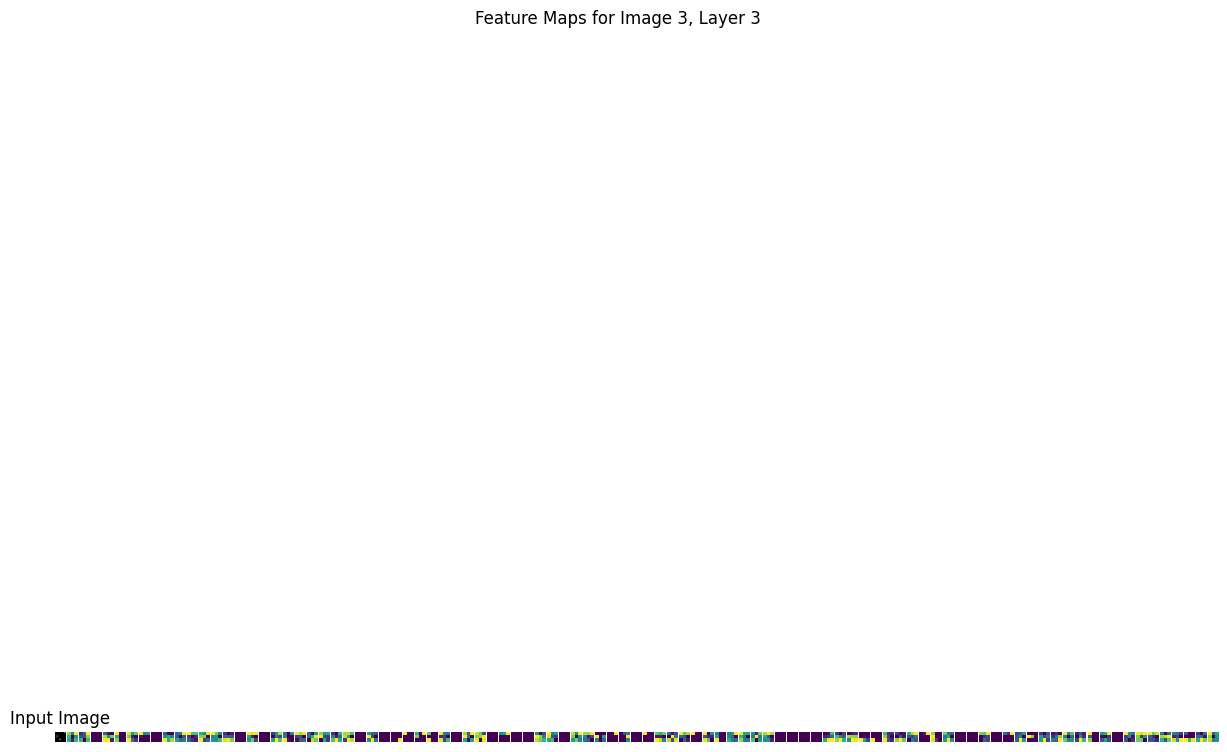

In [ ]:
import matplotlib.pyplot as plt
import torch

def visualize_feature_maps_all_layers(model, images):
    """
    Visualize feature maps for each convolutional layer in the model for a batch of images.

    Parameters:
        model (torch.nn.Module): The model containing convolutional layers.
        images (torch.Tensor): A batch of input images.
    """
    model.eval()
    with torch.no_grad():
        for idx, image in enumerate(images):
            # Forward pass through the model to get output and feature maps
            output, feature_maps = model(image.unsqueeze(0))

            # Iterate over feature maps from each layer
            for layer_idx, feature_map in enumerate(feature_maps):
                feature_map = feature_map.squeeze(0)  # Remove batch dimension

                # Plot the feature maps for the current layer
                num_features = feature_map.size(0)  # Number of filters in the layer
                fig, axes = plt.subplots(1, num_features + 1, figsize=(15, 15))

                # Display the original input image
                axes[0].imshow(image.squeeze(0).cpu().numpy(), cmap='gray')
                axes[0].set_title("Input Image")
                axes[0].axis("off")

                # Display each feature map
                for i in range(num_features):
                    axes[i + 1].imshow(feature_map[i].cpu().numpy(), cmap='viridis')
                    axes[i + 1].axis("off")

                plt.suptitle(f"Feature Maps for Image {idx+1}, Layer {layer_idx+1}")
                plt.show()

# Example usage
# Assume `sample_images` is a batch of images with shape [batch_size, 1, 28, 28]
# For example: sample_images = next(iter(train_loader))[0][:4]  # If using DataLoader for MNIST
sample_images = [train_loader.dataset[i][0] for i in range(3)]
model = CNN_vis(num_layers=3, dropout_rate=0.5, task='classification')
visualize_feature_maps_all_layers(model, sample_images)


 **Feature Maps** from different layers should reveal a hierarchy of features learned by the model:

### First Convolutional Layer:

The initial layer typically captures basic features like edges, gradients, and textures.
Feature maps at this stage might show high responses (bright areas) around regions with strong contrasts, like the borders and curves of the digits.
This layer focuses on simple patterns, which are necessary building blocks for recognizing more complex shapes in deeper layers.
### Second Convolutional Layer:

By this layer, the network starts capturing slightly more complex patterns like small shapes or parts of the digits (e.g., loops or intersections).
Feature maps might highlight parts of individual digits, such as the tops, bottoms, or other unique sections that differentiate the digits.
These features contribute to identifying distinct parts of the three-digit numbers.
### Third Convolutional Layer:

In deeper layers, the feature maps focus on more abstract features that represent combinations of patterns seen in previous layers.
Here, the network learns high-level features that capture the structure of the entire three-digit sequence, possibly recognizing each digit as a separate entity within the input.